In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [117]:
def get_csv(epoch):
    return pd.read_csv(f'outputs++/batches_permutations_model=BasicConv(in_channels=1, out_classes=2)_epoch={epoch}.csv')

In [118]:
N_EPOCHS = 13
dfs = [get_csv(e) for e in range(N_EPOCHS)]

In [119]:
for e in range(N_EPOCHS):
    dfs[e] = dfs[e].rename(columns={
        'FinalBatches': f'Epoch{e}Batches',
        'FinalBatchesIndexes': f'FinalBatchesIndexes_{e}',
        'FinalPermutationIndex': f'FinalPermutationIndex_{e}',
        'TestLoss': f'TestLoss_{e}',
        'TestCorrect': f'TestCorrect_{e}',
        'TestTotal': f'TestTotal_{e}',
        'TestAcc': f'TestAcc_{e}',
    })

In [120]:
merged = [dfs[0]]
for e in range(1, N_EPOCHS):
    new_merged = merged[e - 1].merge(dfs[e], how='inner', on=[f'Epoch{prev_epoch}Batches' for prev_epoch in range(e)])
    merged.append(new_merged)

In [121]:
def correlations(from_column, to_column, method='pearson', fixed_diff=None):
#     print(f'Pearson correlation coefficients from column {from_column} to {to_column}:')
    corrs = {'FromEpoch': [], 'ToEpoch': [], 'Correlation': []}
    for epoch in range(1, N_EPOCHS):
        if fixed_diff is not None:
            prev_range = range(max(0, epoch - fixed_diff), epoch - fixed_diff + 1)
        else:
            also_check_against_same_epoch = 1 if from_column != to_column else 0
            prev_range = range(0, epoch + also_check_against_same_epoch)
            
        for prev_epoch in prev_range:
            m = merged[epoch]
            corr = m[f'{from_column}_{prev_epoch}'].corr(m[f'{to_column}_{epoch}'])
#             print(f'{prev_epoch} -> {epoch}: {corr}')
            corrs['FromEpoch'].append(prev_epoch)
            corrs['ToEpoch'].append(epoch)
            corrs['Correlation'].append(corr)
    return pd.DataFrame.from_dict(corrs)

In [122]:
def print_corr_all_deltas(corrs):
    for d in range(1, 4):
        c = corrs[corrs['FromEpoch'] == corrs['ToEpoch'] - d]
        n = c.shape[0]
        mid = (n + 1) // 2
        first_half = c.iloc[:mid]
        second_half = c.iloc[mid:]
        print(first_half.shape[0], second_half.shape[0])

        print(f'd={d} all     : {c["Correlation"].mean()}')
        print(f'd={d} 1st half: {first_half["Correlation"].mean()}')
        print(f'd={d} 2nd half: {second_half["Correlation"].mean()}')

        

#         print(f'd={d} all     : {c["Correlation"].mean()}')
#         print(f'd={d} 1st half: {first_half["Correlation"].mean()}')
#         print(f'd={d} 2nd half: {second_half["Correlation"].mean()}')
        
        
# os.makedirs('csvs', exist_ok=True)
# out_csv = 'csvs/corr_loss_loss.csv'
# assert not os.path.isfile(out_csv)
# corrs.to_csv(out_csv, index=False)

In [126]:
corrs = correlations('TestLoss', 'TestLoss', fixed_diff=None)
# print_corr_all_deltas(corrs)

In [131]:
corrs = correlations('TestLoss', 'TestLoss', fixed_diff=None)

print(r'\begin{table}[H]')
print(r'\centering')
print(r'\begin{tabular}{l c c c c}')
print(r'\cmidrule[2pt]{1-4}')
head = ' & '.join([
    r'\multirow{1}{*}{\textbf{DeltaEpoch}}',
    r'\multicolumn{1}{c}{AvgCorrEpochs[1-6]}',
    r'\multicolumn{1}{c}{AvgCorrEpochs[7-13]}',
    r'\multicolumn{1}{c}{AvgCorrEpochs[1-13]}',
]) + r' \\'
print(head)
print(r'\cmidrule{1-4}')

for d in range(1, 4):
    c = corrs[corrs['FromEpoch'] == corrs['ToEpoch'] - d]
    print('NaNs:', c['Correlation'].isnull().values.sum()) 
    n = c.shape[0]
    mid = (n + 1) // 2
    first_half = c.iloc[:mid]
    second_half = c.iloc[mid:]
    s = '\t' + r'\hfill ' + '{} & {:.3f} & {:.3f} & {:.3f} \\\\'.format(d, first_half["Correlation"].mean(), second_half["Correlation"].mean(), c["Correlation"].mean())
    print(s)
#         print(first_half.shape[0], second_half.shape[0])
print(r'\cmidrule{1-4}')
print(r'\end{tabular}')
print(r'\caption{Pearson correlations between test losses\label{tab:correlations_test_losses}}')
print(r'\end{table}')

\begin{table}[H]
\centering
\begin{tabular}{l c c c c}
\cmidrule[2pt]{1-4}
\multirow{1}{*}{\textbf{DeltaEpoch}} & \multicolumn{1}{c}{AvgCorrEpochs[1-6]} & \multicolumn{1}{c}{AvgCorrEpochs[7-13]} & \multicolumn{1}{c}{AvgCorrEpochs[1-13]} \\
\cmidrule{1-4}
NaNs: 0
	\hfill 1 & -0.275 & 0.041 & -0.117 \\
NaNs: 0
	\hfill 2 & 0.017 & 0.164 & 0.083 \\
NaNs: 1
	\hfill 3 & -0.056 & 0.010 & -0.027 \\
\cmidrule{1-4}
\end{tabular}
\caption{Pearson correlations between test losses\label{tab:correlations_test_losses}}
\end{table}


In [83]:
corrs = correlations('TestAcc', 'TestAcc')
print_corr_all_deltas(corrs)

6 6
d=1 all     : -0.1079790826382764
d=1 1st half: -0.2748973080768131
d=1 2nd half: 0.05893914280026033
6 5
d=2 all     : 0.11139868684314283
d=2 1st half: 0.016689350940818647
d=2 2nd half: 0.2534626906966291
5 5
d=3 all     : -0.016342751976741926
d=3 1st half: -0.05626907347738348
d=3 2nd half: 0.05020111719099401


In [68]:
corrs = correlations('TestAcc', 'TestAcc')
os.makedirs('csvs', exist_ok=True)
out_csv = 'csvs/corr_test_acc_test_acc.csv'
assert not os.path.isfile(out_csv)
corrs.to_csv(out_csv, index=False)

In [36]:
os.makedirs('plots', exist_ok=True)

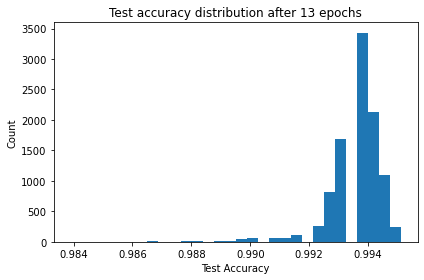

In [133]:
for i in range(N_EPOCHS):
    plt.clf()
    plt.title(f'Test accuracy distribution after {i+1} {"epoch" if i == 0 else "epochs"}')
    plt.hist(merged[i][f'TestAcc_{i}'], bins=30)
    plt.xlabel('Test Accuracy')
    plt.ylabel('Count')
    plt.tight_layout()
    out_png = f'plots/test_acc_dist_after_{i+1}_epochs.png'
    assert not os.path.isfile(out_png)
    plt.savefig(out_png)
#     plt.show()

In [134]:
means = [dfs[i][f'TestAcc_{i}'].mean() for i in range(N_EPOCHS)]
meds  = [dfs[i][f'TestAcc_{i}'].median() for i in range(N_EPOCHS)]
maxs  = [dfs[i][f'TestAcc_{i}'].max() for i in range(N_EPOCHS)]
mins  = [dfs[i][f'TestAcc_{i}'].min() for i in range(N_EPOCHS)]

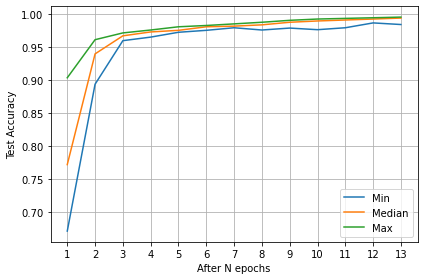

In [136]:
x = range(1, N_EPOCHS + 1)
plt.plot(x, mins, label='Min')
# plt.plot(means, label='Mean')
plt.plot(x, meds, label='Median')
plt.plot(x, maxs, label='Max')

plt.xticks(x)
plt.xlabel('After N epochs')
plt.ylabel('Test Accuracy')
plt.grid()
plt.legend()
plt.tight_layout()
out_png = 'plots/test_acc_all_epochs.png'
assert not os.path.isfile(out_png)
plt.savefig(out_png)

In [54]:
for mn, md, mean, mx in zip(mins, meds, means, maxs):
    print(mn, md, mean, mx)

0.67138671875 0.77197265625 0.7755398220486112 0.9033203125
0.8935546875 0.939453125 0.937208726671007 0.9609375
0.95947265625 0.966796875 0.9663064139229911 0.97119140625
0.96484375 0.97265625 0.9726129441034226 0.9755859375
0.97216796875 0.97509765625 0.9762707907056052 0.98046875
0.97509765625 0.98046875 0.9798473539806548 0.982421875
0.97900390625 0.9814453125 0.98154296875 0.98486328125
0.9755859375 0.9833984375 0.9834171355716765 0.9873046875
0.978515625 0.9873046875 0.9870466928633432 0.990234375
0.97607421875 0.9892578125 0.9888883560422868 0.9921875
0.97900390625 0.99072265625 0.9895095582992312 0.9931640625
0.986328125 0.9921875 0.9912748790922619 0.994140625
0.9912109375 0.99365234375 0.9933253046291978 0.99462890625


In [139]:
for i in range(N_EPOCHS):
    best_prev_vs_med = i
    best_prev_vs_min = i
    best_prev_vs_avg = i
    for prev in range(i - 1, 0, -1):
        if maxs[prev] >= mins[i]:
            best_prev_vs_min = prev
        if maxs[prev] >= meds[i]:
            best_prev_vs_med = prev
        if maxs[prev] >= means[i]:
            best_prev_vs_avg = prev
    if best_prev_vs_med != i:
        print(f'best_prev_vs_med({i}) = {i - best_prev_vs_med}')
#     if best_prev_vs_avg != i:
#         print(f'best_prev_vs_avg({i}) = {i - best_prev_vs_avg}')
#     if best_prev_vs_min != i:
#         print(f'best_prev_vs_min({i}) = {i - best_prev_vs_min}')

best_prev_vs_med(4) = 1
best_prev_vs_med(5) = 1
best_prev_vs_med(6) = 1
best_prev_vs_med(7) = 1
best_prev_vs_med(8) = 1
best_prev_vs_med(9) = 1
best_prev_vs_med(10) = 1
best_prev_vs_med(11) = 2
best_prev_vs_med(12) = 1


In [140]:
# \begin{tabular}{l c c c c c}
#     \cmidrule[2pt]{1-5} %\toprule
#     \multirow{1}{*}{\textbf{Epochs}} & \multicolumn{1}{c}{Max Accuracy} & \multicolumn{1}{c}{Min Accuracy} & \multicolumn{1}{c}{Max Loss} & \multicolumn{1}{c}{Min Loss} \\ 
#     \cmidrule{1-5}
#     \hfill 1 & 0.9033203125 & 0.6713867188 & 2.449115098 & 2.393164754 \\

#     \hfill 2 & 0.9609375 & 0.8935546875 & 1.71363318 & 1.643359601 \\

#     \hfill 3 & 0.9711914063 & 0.9594726563 & 1.023167834 & 0.9834425896 \\

#     \hfill 4 & 0.9755859375 & 0.96484375 & 0.7668097764 & 0.6259695292 \\
#     \cmidrule[2pt]{1-5}
# \end{tabular}

# means = [dfs[i][f'TestAcc_{i}'].mean() for i in range(N_EPOCHS)]
# meds  = [dfs[i][f'TestAcc_{i}'].median() for i in range(N_EPOCHS)]
# maxs  = [dfs[i][f'TestAcc_{i}'].max() for i in range(N_EPOCHS)]
# mins  = [dfs[i][f'TestAcc_{i}'].min() for i in range(N_EPOCHS)]

print(r'\begin{table}[H]')
print(r'\centering')
print(r'\begin{tabular}{l c c c c c c}')
print(r'\cmidrule[2pt]{1-6}')
head = ' & '.join([
    r'\multirow{1}{*}{\textbf{Epoch}}',
    r'\multicolumn{1}{c}{Min Accuracy}',
    r'\multicolumn{1}{c}{Mean Accuracy}',
    r'\multicolumn{1}{c}{Max Accuracy}',
    r'\multicolumn{1}{c}{Min Loss}',
    r'\multicolumn{1}{c}{Max Loss}',
]) + r' \\'
print(head)
print(r'\cmidrule{1-6}')
for e in range(N_EPOCHS):
    acc = dfs[e][f'TestAcc_{e}']
    loss = dfs[e][f'TestLoss_{e}']
    s = '\t' + r'\hfill ' + '{} & {:.3f} & {:.3f} & {:.3f} & {:.3f} & {:.3f} \\\\'.format(e+1, acc.min(), acc.mean(), acc.max(), loss.min(), loss.max())
    print(s)
print(r'\cmidrule{1-6}')
print(r'\end{tabular}')
print(r'\caption{Summary of results on test data after each epoch\label{tab:summary}}')
print(r'\end{table}')

\begin{table}[H]
\centering
\begin{tabular}{l c c c c c c}
\cmidrule[2pt]{1-6}
\multirow{1}{*}{\textbf{Epoch}} & \multicolumn{1}{c}{Min Accuracy} & \multicolumn{1}{c}{Mean Accuracy} & \multicolumn{1}{c}{Max Accuracy} & \multicolumn{1}{c}{Min Loss} & \multicolumn{1}{c}{Max Loss} \\
\cmidrule{1-6}
	\hfill 1 & 0.671 & 0.776 & 0.903 & 2.393 & 2.449 \\
	\hfill 2 & 0.894 & 0.937 & 0.961 & 1.643 & 1.714 \\
	\hfill 3 & 0.959 & 0.966 & 0.971 & 0.983 & 1.023 \\
	\hfill 4 & 0.965 & 0.973 & 0.976 & 0.626 & 0.767 \\
	\hfill 5 & 0.972 & 0.976 & 0.980 & 0.431 & 0.582 \\
	\hfill 6 & 0.975 & 0.980 & 0.982 & 0.322 & 0.429 \\
	\hfill 7 & 0.979 & 0.982 & 0.985 & 0.254 & 0.294 \\
	\hfill 8 & 0.976 & 0.983 & 0.987 & 0.217 & 0.324 \\
	\hfill 9 & 0.979 & 0.987 & 0.990 & 0.190 & 0.294 \\
	\hfill 10 & 0.976 & 0.989 & 0.992 & 0.178 & 0.345 \\
	\hfill 11 & 0.979 & 0.990 & 0.993 & 0.162 & 0.320 \\
	\hfill 12 & 0.986 & 0.991 & 0.994 & 0.144 & 0.237 \\
	\hfill 13 & 0.984 & 0.994 & 0.995 & 0.126 & 0.269 \\
\cmidrule{